#Importing libraries

In [1]:
# Mount Google Drive for Google Colab
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/ESP4901_FYP'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/ESP4901_FYP
/content/gdrive/My Drive/ESP4901_FYP


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.utils import load_img
import keras.utils

from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

In [3]:
tf.keras.backend.clear_session()

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#Data Analysis

In [5]:
train_dir = '../ESP4901_FYP/archive/train/'
test_dir = '../ESP4901_FYP/archive/test/'

#image size: HEIGHT=48, WIDTH=48
#number of classes=7

#Count data for each emotion for train and test set
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']
df = pd.DataFrame(columns=class_names,
                  index=['train', 'test'])

def data_in_class(path, dataframe, set):
  classes = {}
  directory_files = os.listdir(path)
  for emotion in directory_files:
    emotion_directory = path + emotion
    classes[emotion] = len(os.listdir(emotion_directory))
    dataframe.loc[[set],emotion] = classes[emotion]
  return dataframe

df = data_in_class(train_dir, df, 'train')
df = data_in_class(test_dir, df, 'test')
print(df)

      angry disgust  fear happy neutral   sad surprise
train  3995     436  4097  7225    4965  4830     3171
test    958     111  1024  1774    1233  1247      831


<Axes: >

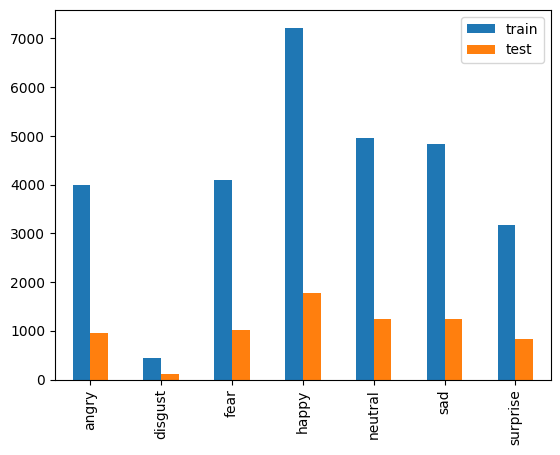

In [6]:
df.transpose().plot(kind='bar')

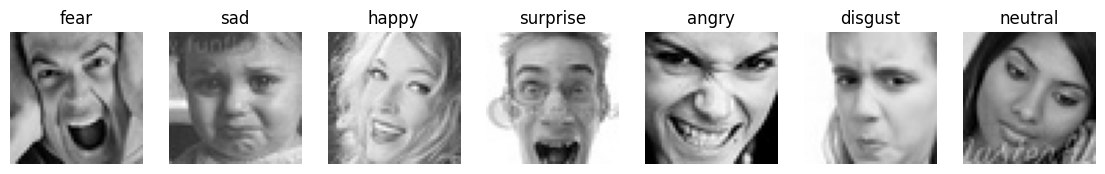

In [7]:
plt.figure(figsize=(14,22))
i = 1

directory_files = os.listdir(train_dir)

for emotion in directory_files:
    emotion_directory = train_dir + emotion
    emotion_data = os.listdir(emotion_directory)[7]
    img = load_img((emotion_directory +'/'+ emotion_data))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
    i += 1

plt.show()

In [8]:
"""
#set parameters
#batchSize = 64
#height=48
#width=48

(train_ds, val_ds) = keras.utils.image_dataset_from_directory(train_dir,
                                                    color_mode='grayscale',
                                                    batch_size=64,
                                                    image_size=(48, 48),
                                                    shuffle=True,
                                                    seed=42,
                                                    validation_split=0.25,
                                                    subset='both')

test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                    color_mode='grayscale',
                                                    batch_size=64,
                                                    image_size=(48, 48),
                                                    shuffle=True)
"""

"\n#set parameters\n#batchSize = 64\n#height=48\n#width=48\n\n(train_ds, val_ds) = keras.utils.image_dataset_from_directory(train_dir,\n                                                    color_mode='grayscale',\n                                                    batch_size=64,\n                                                    image_size=(48, 48),\n                                                    shuffle=True,\n                                                    seed=42,\n                                                    validation_split=0.25,\n                                                    subset='both')\n\ntest_ds = keras.utils.image_dataset_from_directory(test_dir,\n                                                    color_mode='grayscale',\n                                                    batch_size=64,\n                                                    image_size=(48, 48),\n                                                    shuffle=True)\n"

In [9]:
#set parameters
#batchSize = 64
#height=48
#width=48

(test_ds, val_ds) = keras.utils.image_dataset_from_directory(test_dir,
                                                    color_mode='grayscale',
                                                    batch_size=64,
                                                    image_size=(48, 48),
                                                    shuffle=True,
                                                    seed=42,
                                                    validation_split=0.5,
                                                    subset='both')

train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                                    color_mode='grayscale',
                                                    batch_size=64,
                                                    image_size=(48, 48),
                                                    shuffle=True)

Found 7178 files belonging to 7 classes.
Using 3589 files for training.
Using 3589 files for validation.
Found 28719 files belonging to 7 classes.


In [10]:
#labels
labels=train_ds.class_names

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Create CNN Model

In [12]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))                                                                                                                           
model.add(BatchNormalization())                
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [15]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best_2.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

#Train the model

In [16]:
steps_per_epoch = 25140 // 64
validation_steps = 7179 // 64

history = model.fit(x=train_ds,
                 validation_data=val_ds,
                 epochs=200,
                 callbacks=[checkpointer])
                 #steps_per_epoch=steps_per_epoch,
                 #validation_steps=validation_steps

Epoch 1/200
449/449 [==============================] - ETA: 0s - loss: 1.9188 - accuracy: 0.2743
Epoch 1: val_accuracy improved from -inf to 0.36668, saving model to model.weights.best_2.hdf5
449/449 [==============================] - 2273s 5s/step - loss: 1.9188 - accuracy: 0.2743 - val_loss: 1.6626 - val_accuracy: 0.3667
Epoch 2/200
449/449 [==============================] - ETA: 0s - loss: 1.6622 - accuracy: 0.3658
Epoch 2: val_accuracy improved from 0.36668 to 0.42742, saving model to model.weights.best_2.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 1.6622 - accuracy: 0.3658 - val_loss: 1.5245 - val_accuracy: 0.4274
Epoch 3/200
448/449 [============================>.] - ETA: 0s - loss: 1.5433 - accuracy: 0.4174
Epoch 3: val_accuracy improved from 0.42742 to 0.46252, saving model to model.weights.best_2.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 1.5431 - accuracy: 0.4175 - val_loss: 1.4418 - val_accuracy: 0.4625
Epoch 4/200
449/449

#Visualise Results

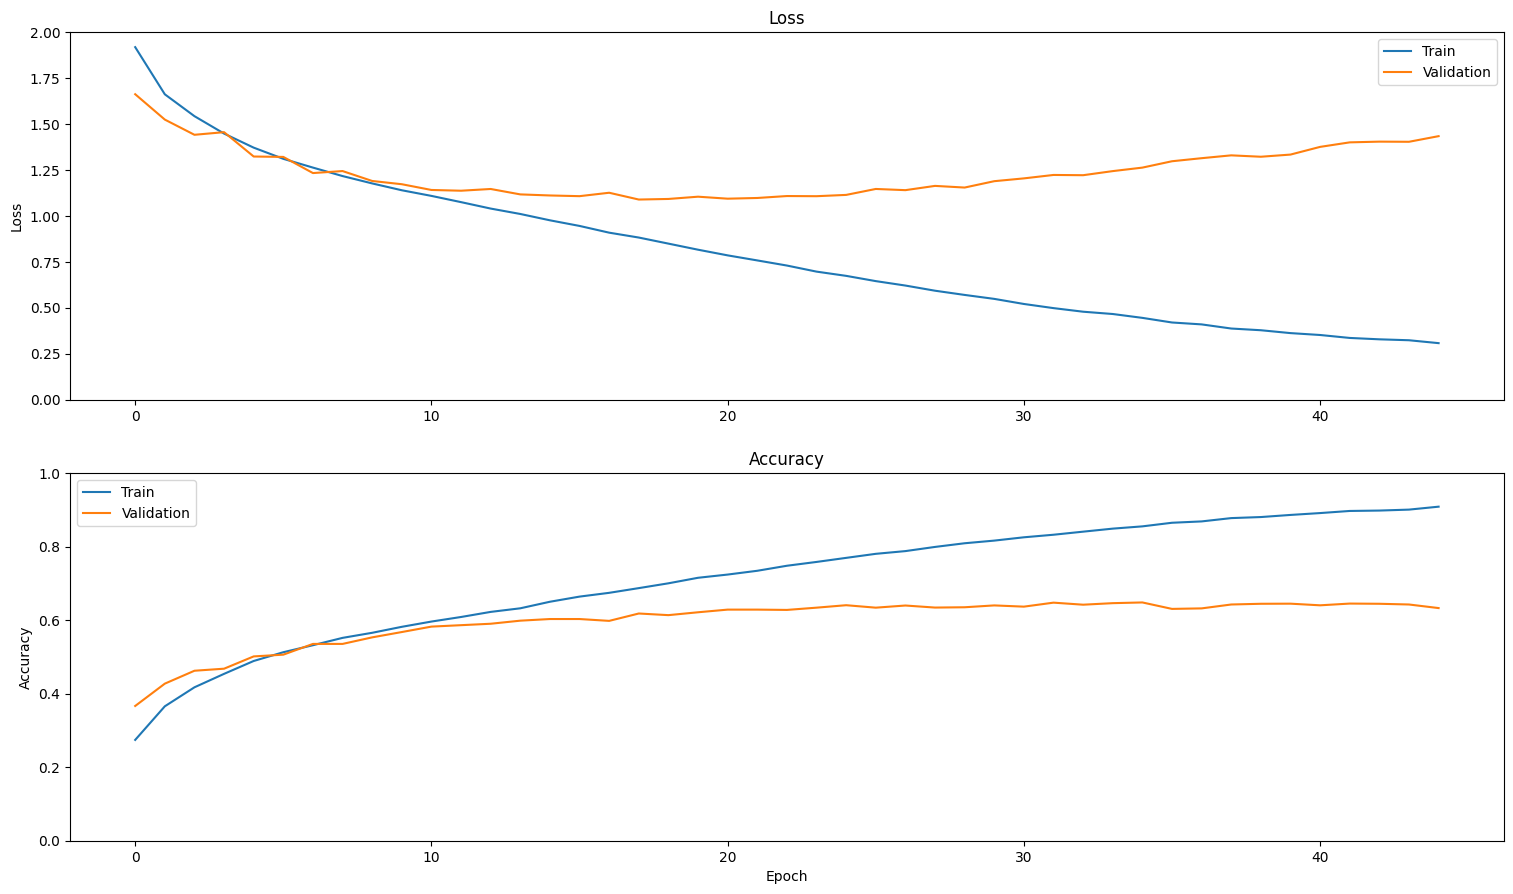

In [17]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  ax1.set_facecolor("white")

  for ax in [ax1, ax2]:
   plt.setp(ax.spines.values(), color='black')
   plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  #ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], facecolor='white') 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'], facecolor='white')
  ax2.set_facecolor("white")

  plt.grid(False)
  plt.show()

plot_history(history)

In [18]:
#save model
model.save("pre-trained_model.h5")

#Evaluate Model

In [19]:
model = keras.models.load_model("pre-trained_model.h5")

In [20]:
model.evaluate(test_ds, return_dict=True)

57/57 [==============================] - 267s 4s/step - loss: 1.3520 - accuracy: 0.6163


{'loss': 1.351959466934204, 'accuracy': 0.6163276433944702}

##Confusion Matrix

In [21]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

57/57 [==============================] - 2s 24ms/step


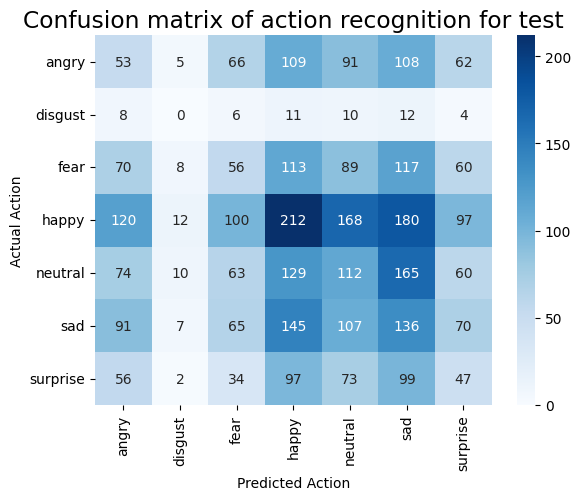

In [23]:
#Test
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

##Precision and Recall values

In [24]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [25]:
#Test
precision, recall = actual, predicted = calculate_classification_metrics(actual, predicted, labels)
print(precision)
print(recall)

{'angry': 0.11228813559322035, 'disgust': 0.0, 'fear': 0.14358974358974358, 'happy': 0.25980392156862747, 'neutral': 0.1723076923076923, 'sad': 0.1664626682986536, 'surprise': 0.1175}
{'angry': 0.10728744939271255, 'disgust': 0.0, 'fear': 0.10916179337231968, 'happy': 0.23847019122609675, 'neutral': 0.18270799347471453, 'sad': 0.21900161030595813, 'surprise': 0.11519607843137254}
